In [26]:
!pip -q install geopandas shapely pyproj fiona pandas

In [27]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# 프로젝트 루트 (필요시 이 한 줄만 수정)
ROOT = '/content/drive/MyDrive/colab/firecast'

# 데이터 경로
P_FIRE_DIR   = f'{ROOT}/data/raw/fires/FRT000102_42'   # 샘플 구조: .../fires/FRT000102_42/ TB_FFAS_FF_OCCRR_42.*
P_WEATHER_DIR= f'{ROOT}/data/raw/weather'
P_PROC_DIR   = f'{ROOT}/data/processed'
P_FEAT_DIR   = f'{ROOT}/data/features'

import os
os.makedirs(P_PROC_DIR, exist_ok=True)
os.makedirs(P_FEAT_DIR, exist_ok=True)

print('ROOT:', ROOT)
print('FIRE_DIR:', P_FIRE_DIR)
print('WEATHER_DIR:', P_WEATHER_DIR)


Mounted at /content/drive
ROOT: /content/drive/MyDrive/colab/firecast
FIRE_DIR: /content/drive/MyDrive/colab/firecast/data/raw/fires/FRT000102_42
WEATHER_DIR: /content/drive/MyDrive/colab/firecast/data/raw/weather


In [28]:
import geopandas as gpd
import glob, os, pandas as pd

# shapefile 경로 찾기
shp_candidates = glob.glob(os.path.join(P_FIRE_DIR, '*.shp'))
assert len(shp_candidates) == 1, f'*.shp가 1개가 아닙니다: {shp_candidates}'
FIRE_SHP = shp_candidates[0]
print('FIRE_SHP:', FIRE_SHP)

fires = gpd.read_file(FIRE_SHP)
print('rows, cols:', fires.shape)
print('CRS:', fires.crs)
print('bounds:', fires.total_bounds)
print('columns:', list(fires.columns))


# OCCRR_DTM의 앞 4자리(연도)만 추출
fires['YEAR'] = fires['OCCRR_DTM'].astype(str).str[:4]

# 2020년, 2021년 데이터만 필터링
fires = fires[fires['YEAR'].isin(['2020', '2021'])].copy()

fires.shape, fires.head()
fires = fires.drop(columns=['YEAR'])

# # 상위 5행
# fires.head()

from IPython.display import display
display(fires)

FIRE_SHP: /content/drive/MyDrive/colab/firecast/data/raw/fires/FRT000102_42/TB_FFAS_FF_OCCRR_42.shp
rows, cols: (4851, 16)
CRS: EPSG:5179
bounds: [ 966300.7972 1897781.2045 1168663.2316 2065396.7145]
columns: ['OCCRR_DTM', 'OCUR_DYWK', 'EXTING_DTM', 'RQRMN_TM', 'ARA_NM', 'CTPRV_NM', 'SGNG_NM', 'EMNDN_NM', 'OCCCRR_RI', 'ARA_LTNMB', 'CUSE_NM', 'DMG_AREA', 'DMG_MONEY', 'TM_X', 'TM_Y', 'geometry']


,OCCRR_DTM,OCUR_DYWK,EXTING_DTM,RQRMN_TM,ARA_NM,CTPRV_NM,SGNG_NM,EMNDN_NM,OCCCRR_RI,ARA_LTNMB,CUSE_NM,DMG_AREA,DMG_MONEY,TM_X,TM_Y,geometry
1188,202001011256,None,None,None,강원,강원도,강릉시,성산면,위촌리,877,None,None,None,1118130.2983,1974379.7313,POINT (1118130.298 1974379.731)
1189,202001031238,None,None,None,강원,강원도,삼척시,신기면,대이리,30,None,None,None,1136718.9552,1926753.614,POINT (1136718.955 1926753.614)
1190,202001031222,None,None,None,강원,강원도,춘천시,서면,오월리,산35-1,None,None,None,1013066.9954,1997730.7497,POINT (1013066.995 1997730.75)
1191,202001041354,None,None,None,강원,강원도,춘천시,신북읍,발산리,산30-1,None,None,None,1020857.7361,1997186.1272,POINT (1020857.736 1997186.127)
1192,202001041354,None,None,None,강원,강원도,춘천시,신북읍,발산리,738-38,None,None,None,1021648.0183,1996929.9925,POINT (1021648.018 1996929.992)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4846,202105141930,None,None,None,충북,충청북도,제천시,금성면,위림리,178,None,None,None,1059890.311,1998165.9583,POINT (1059890.311 1998165.958)
4847,202105151051,None,None,None,강원,강원도,횡성군,안흥면,상안리,산35,None,None,None,1061235.3857,1934246.1822,POINT (1061235.386 1934246.182)
4848,202105162035,None,None,None,충북,충청북도,괴산군,연풍면,적석리,705-2,None,None,None,1041610.032,1962724.3128,POINT (1041610.032 1962724.313)
4849,202105180946,None,None,None,강원,강원도,정선군,정선읍,봉양리,508-1,None,None,None,1100902.6635,1933126.3324,POINT (1100902.663 1933126.332)


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['YEAR'].plot(kind='hist', bins=20, title='YEAR')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['MONTH'].plot(kind='hist', bins=20, title='MONTH')
plt.gca().spines[['top', 'right',]].set_visible(False)

/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 45224 (\N{HANGUL SYLLABLE NAM}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 48513 (\N{HANGUL SYLLABLE BUG}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 52649 (\N{HANGUL SYL

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('ARA_NM').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 45224 (\N{HANGUL SYL

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('CTPRV_NM').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='index', y='YEAR', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='YEAR', y='MONTH', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 45224 (\N{HANGUL SYLLABLE NAM}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 48513 (\N{HANGUL SYLLABLE BUG}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 52649 (\N{HANGUL SYL

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['OCCRR_DATE']
  ys = series['MONTH']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('OCCRR_DATE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('ARA_NM')):
  _plot_series(series, series_name, i)
  fig.legend(title='ARA_NM', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('OCCRR_DATE')
_ = plt.ylabel('MONTH')

/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 45224 (\N{HANGUL SYL

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['OCCRR_DATE']
  ys = series['MONTH']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('OCCRR_DATE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('CTPRV_NM')):
  _plot_series(series, series_name, i)
  fig.legend(title='CTPRV_NM', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('OCCRR_DATE')
_ = plt.ylabel('MONTH')

/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 45224 (\N{HANGUL SYLLABLE NAM}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 48513 (\N{HANGUL SYLLABLE BUG}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 52649 (\N{HANGUL SYL

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['OCCRR_DATE']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'OCCRR_DATE'}, axis=1)
              .sort_values('OCCRR_DATE', ascending=True))
  xs = counted['OCCRR_DATE']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('OCCRR_DATE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('ARA_NM')):
  _plot_series(series, series_name, i)
  fig.legend(title='ARA_NM', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('OCCRR_DATE')
_ = plt.ylabel('count()')

/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 45224 (\N{HANGUL SYL

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['OCCRR_DATE']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'OCCRR_DATE'}, axis=1)
              .sort_values('OCCRR_DATE', ascending=True))
  xs = counted['OCCRR_DATE']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('OCCRR_DATE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('CTPRV_NM')):
  _plot_series(series, series_name, i)
  fig.legend(title='CTPRV_NM', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('OCCRR_DATE')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_11['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_12['YEAR'].plot(kind='line', figsize=(8, 4), title='YEAR')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['MONTH'].plot(kind='line', figsize=(8, 4), title='MONTH')
plt.gca().spines[['top', 'right']].set_visible(False)

/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 45224 (\N{HANGUL SYLLABLE NAM}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 48513 (\N{HANGUL SYLLABLE BUG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 52649 (\N{HANGUL SYLLABLE CUNG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw(

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['CTPRV_NM'].value_counts()
    for x_label, grp in _df_14.groupby('ARA_NM')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('ARA_NM')
_ = plt.ylabel('CTPRV_NM')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 45224 (\N{HANGUL SYLLABLE NAM}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 5

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_15['ARA_NM'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_15, x='index', y='ARA_NM', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 49

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_16['CTPRV_NM'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_16, x='index', y='CTPRV_NM', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 45224 (\N{HANGUL SYLLABLE NAM}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 5

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['ARA_NM'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='YEAR', y='ARA_NM', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 49

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_18['CTPRV_NM'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_18, x='YEAR', y='CTPRV_NM', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [29]:
show_cols = [c for c in ['CTPRV_NM','SGNG_NM','EMNDN_NM','OCCCR_RI','OCCRR_DTM','OCUR_DYWK'] if c in fires.columns]
for c in show_cols:
    print(f'\n[{c}] top values:')
    print(fires[c].astype('string').value_counts(dropna=False).head(10))



[CTPRV_NM] top values:
CTPRV_NM
강원도     3402
충청북도     256
경상남도       2
<NA>       2
경상북도       1
Name: count, dtype: Int64

[SGNG_NM] top values:
SGNG_NM
동해시    477
양양군    337
평창군    334
원주시    282
홍천군    249
철원군    233
영월군    231
횡성군    229
강릉시    194
화천군    173
Name: count, dtype: Int64

[EMNDN_NM] top values:
EMNDN_NM
천곡동    211
대화면    142
동송읍    120
서면     111
지정면     77
양양읍     75
현남면     72
사내면     67
영월읍     65
강현면     64
Name: count, dtype: Int64

[OCCRR_DTM] top values:
OCCRR_DTM
202102021016    19
202102051030    16
202010201048    15
202010201341    15
202010201346    14
202102020938    13
202102020937    13
202010211430    12
202102020935    12
202102031003    12
Name: count, dtype: Int64

[OCUR_DYWK] top values:
OCUR_DYWK
<NA>    3663
Name: count, dtype: Int64


In [30]:
import numpy as np

# 예: OCCRR_DTM = 'YYYYMMDDHHMM' 형태일 가능성
date_col = 'OCCRR_DTM' if 'OCCRR_DTM' in fires.columns else None
if date_col:
    # 길이가 8 이상이면 YYYYMMDD까지만 파싱
    fires['OCCRR_DATE_STR'] = fires[date_col].astype('string').str.slice(0,8)
    fires['OCCRR_DATE'] = pd.to_datetime(fires['OCCRR_DATE_STR'], errors='coerce', format='%Y%m%d')
    fires['YEAR']  = fires['OCCRR_DATE'].dt.year
    fires['MONTH'] = fires['OCCRR_DATE'].dt.month
    fires[['OCCRR_DTM','OCCRR_DATE','YEAR','MONTH']].head()
else:
    print('날짜 컬럼(OCCRR_DTM)이 없어 파생을 건너뜁니다.')


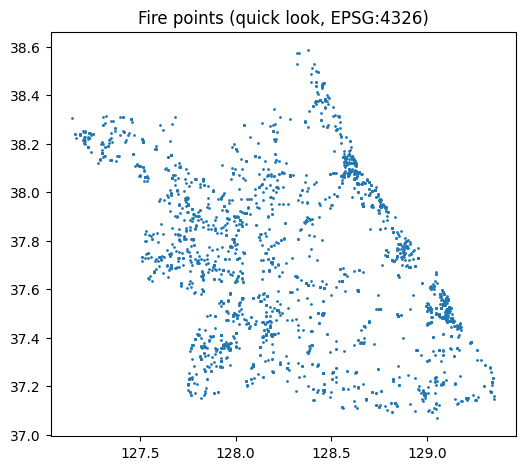

In [31]:
# 웹 지도/시각화 대비 WGS84로 변환
fires_4326 = fires.to_crs('EPSG:4326') if fires.crs and fires.crs.to_string()!='EPSG:4326' else fires.copy()

ax = fires_4326.plot(figsize=(6,6), markersize=1)
_ = ax.set_title('Fire points (quick look, EPSG:4326)')


In [32]:
import glob

csv_list = sorted(glob.glob(os.path.join(P_WEATHER_DIR, '*.csv')))
print('weather csv files:', len(csv_list))
for p in csv_list:
    print('-', os.path.basename(p))

# 첫 몇 개만 열어 컬럼 구조 확인
def pick(cols, candidates):
    cols_low = {c.lower(): c for c in cols}
    for c in candidates:
        if c.lower() in cols_low:
            return cols_low[c.lower()]
    return None

meta = []
for p in csv_list[:2]:  # 샘플 2개만 확인
    df0 = pd.read_csv(p, nrows=50, low_memory=False, encoding='cp949')
    stn_col = pick(df0.columns, ['STN','stn','stnid','지점','지점번호'])
    lat_col = pick(df0.columns, ['LAT','lat','위도'])
    lon_col = pick(df0.columns, ['LON','lon','경도'])
    tmx_col = pick(df0.columns, ['TM_X','tm_x','X','x'])
    tmy_col = pick(df0.columns, ['TM_Y','tm_y','Y','y'])
    meta.append({
        'file': os.path.basename(p),
        'stn_col': stn_col, 'lat_col': lat_col, 'lon_col': lon_col,
        'tmx_col': tmx_col, 'tmy_col': tmy_col,
        'n_rows_look': len(df0)
    })

pd.DataFrame(meta)

weather csv files: 4
- SURFACE_ASOS_104_DAY_2020_2020_2021.csv
- SURFACE_ASOS_104_DAY_2021_2021_2022.csv
- SURFACE_ASOS_105_DAY_2020_2020_2021.csv
- SURFACE_ASOS_105_DAY_2021_2021_2022.csv


,file,stn_col,lat_col,lon_col,tmx_col,tmy_col,n_rows_look
0,SURFACE_ASOS_104_DAY_2020_2020_2021.csv,지점,None,None,None,None,50
1,SURFACE_ASOS_104_DAY_2021_2021_2022.csv,지점,None,None,None,None,50
